### Grover's Algorithm

in Qiskit

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_ibm_runtime import Sampler, QiskitRuntimeService
from qiskit_aer import Aer
import numpy as np
from copy import deepcopy
from collections.abc import Callable
import matplotlib.pyplot as plt

%matplotlib inline

##### We define our system

In [115]:
def grover_init(qr: QuantumRegister) -> QuantumCircuit:
    """Initial part of the circuit for Grover's algorithm.

    Args:
        qr (QuantumRegister): Quantum register with used qubits.

    Returns:
        QuantumCircuit: Resulting circuit.
    """

    qc = QuantumCircuit(qr)
    n = len(qr)
    
    # qubit that receives the oracle output must be set to one
    qc.x(n-1)
    for i in range(n):
        qc.h(qr[i])

    qc.barrier()

    return qc 

In [121]:
def diffusion(qr: QuantumRegister) -> QuantumCircuit:
    """Diffusion section of the circuit.

    Args:
        qr (QuantumRegister): Quantum register with used qubits.

    Returns:
        QuantumCircuit: Resulting circuit.
    """
    qc = QuantumCircuit(qr)

    # diffusion operator
    n = len(qr)
    for i in range(n - 1):
        qc.h(qr[i])
        qc.x(qr[i])

    # to implement multicontrolled Z we use a multicontrolled Z rotation
    mcz = QuantumCircuit(qr, name="cZ")
    if n > 2:
        mcz.mcrz(np.pi, qr[:-2], qr[-2])
    else:
        # (if there is only an input for oracle, we don't have controls)
        mcz.z(qr[0])

    qc.append(mcz.to_instruction(), qr)
    # qc.append(mcz.to_gate(label="cZ"), qr)

    for i in range(n-1):
        qc.x(qr[i])
        qc.h(qr[i])
        
    qc.barrier()

    return qc

In [122]:
def ones(qr: QuantumRegister) -> QuantumCircuit:
    """An oracle function, that returns 1 only if all of the inputs are 1, 
    using multicontrolled X gate.

    Args:
        qr (QuantumRegister): Quantum register with used qubits.

    Returns:
        QuantumCircuit: Resulting circuit.
    """

    qc = QuantumCircuit(qr)
    qc.mcx(qr[:-1], qr[-1])
    
    return qc

In [123]:
def grover(n: int, oracle: Callable, rep: int = 10, measure: bool = True):
    """Construct the full circuit for Grover's algorithm.

    Args:
        n (int): Number of qubits used.
        oracle (Callable): Specific function used as an oracle.
        rep (int, optional): Repetitions of how many times oracle and 
            diffusion supposed to be used. It is analogous to how many 
            rotations we want to make. Defaults to 10.
        measure (bool, optional): Whether to measure at the end. 
            Defaults to True.

    Returns:
        _type_: Resulting quantum circuit.
    """
    qr = QuantumRegister(n, "qr")
    if measure:
        cr = ClassicalRegister(n-1, "cr")
        qc = QuantumCircuit(qr, cr)
    else:
        qc = QuantumCircuit(qc)

    qc.compose(grover_init(qr), inplace=True)

    for _ in range(rep):
        qc.compose(oracle(qr), inplace=True)
        qc.compose(diffusion(qr), inplace=True)

    if measure:
        qc.measure(qr[:n-1], cr)

    return qc

##### Display the composed circuit

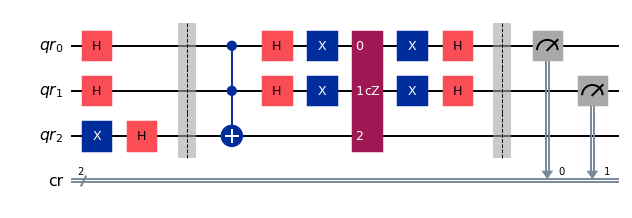

In [144]:
n = 3
qc_grover = grover(n, ones, rep=1)

qc_grover.draw("mpl", scale=0.7);

##### Check on a simulator with a single repetition

In [147]:
backend = Aer.get_backend("qasm_simulator")
comp_qc_grover = transpile(qc_grover, backend)
job = backend.run(comp_qc_grover)
counts = job.result().get_counts()

print(counts)

{'11': 534, '10': 490}


##### And finally see how the probabilities change when we do multiple repetitions

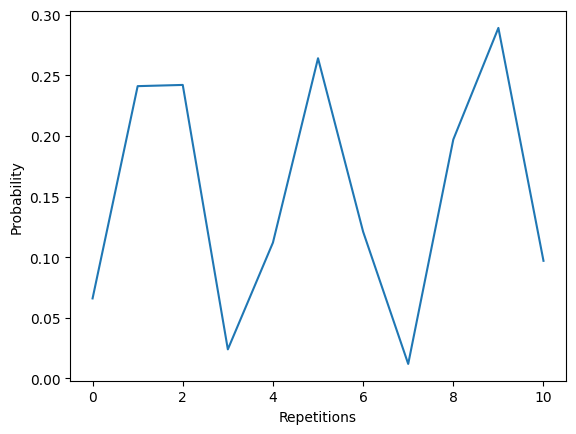

In [149]:
n = 5
reps = 11
shots = 1000
backend = Aer.get_backend(("qasm_simulator"))
target = "1" * (n-1)   # marked string, to retrieve its probability
probs = np.zeros((reps))

for n_reps in range(reps):
    qc = grover(n, ones, n_reps)
    job = backend.run(transpile(qc, backend), shots=shots)
    counts = job.result().get_counts()
    if target in counts.keys():
        probs[n_reps] = counts[target] / shots

plt.xlabel("Repetitions")
plt.ylabel("Probability")
plt.plot(np.arange((reps)), probs)
plt.show()